In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from time import time
import copy

from numba import jit, njit, prange

import pandas as pd


In [3]:
from sortedcontainers import SortedList

from collections import deque
from bisect import bisect_left, insort
from blist import blist

from blist import sortedlist as blist_sortedlist


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# found this on github
"""
Compares some algorithms for computing a sliding median of an array.
Results:
  scipy.signal.medfilt2d is a bit faster than scipy.ndimage.filter.median_filter
  and significantly faster than scipy.signal.medfilt.
  Maintaining a sorted list of the window becomes faster than that for a filter
  length on the order of 100 items or more. Using the builtin `list`
  implementation for that is considerably faster than a `blist.blist`,
  `blist.sortedlist` or `sortedcontainers.SortedList`.
In numbers (Python 2.7.6, numpy 1.8.2, scipy 0.13.3, i7-4770S CPU @ 3.10GHz):
Sequence length 100000, filter width 49:
  scipy.signal.medfilt: 0.224 s
  scipy.signal.medfilt2d: 0.0543 s
  scipy.ndimage.filters.median_filter: 0.0588 s
  using blist.blist: 0.0971 s
  using list: 0.0774 s
  using blist.sortedlist: 0.549 s
  using sortedcontainers.SortedList: 0.284 s
Sequence length 100000, filter width 99:
  scipy.signal.medfilt: 0.495 s
  scipy.signal.medfilt2d: 0.103 s
  scipy.ndimage.filters.median_filter: 0.108 s
  using blist.blist: 0.105 s
  using list: 0.0832 s
  using blist.sortedlist: 0.595 s
  using sortedcontainers.SortedList: 0.291 s
Sequence length 100000, filter width 599:
  scipy.signal.medfilt: 3.85 s
  scipy.signal.medfilt2d: 0.579 s
  scipy.ndimage.filters.median_filter: 0.598 s
  using blist.blist: 0.234 s
  using list: 0.109 s
  using blist.sortedlist: 0.894 s
  using sortedcontainers.SortedList: 0.323 s
Sequence length 100000, filter width 9999:
  scipy.signal.medfilt: 85 s
  scipy.signal.medfilt2d: 8.87 s
  scipy.ndimage.filters.median_filter: 10.1 s
  using blist.blist: 0.612 s
  using list: 0.372 s
  using blist.sortedlist: 1.59 s
  using sortedcontainers.SortedList: 0.505 s
Author: Jan Schlüter
"""

import sys
import os
import numpy as np
import timeit

NUM_REPEATS = 3
NUM_ITER = 3
N = 100000
DATA = None

# Three scipy implementations
import scipy.signal
import scipy.ndimage.filters

def scipy_signal(data, width):
    return scipy.signal.medfilt(data, width)

def scipy_signal2d(data, width):
    return scipy.signal.medfilt2d(data.reshape(1, -1), (1, width))[0]

def scipy_ndimage(data, width):
    return scipy.ndimage.filters.median_filter(data, width)

# An implementation using blist or list, with code adopted
# from http://code.activestate.com/recipes/576930/#c3
# Note that this applies the median filter over the past values,
# while scipy applies it half to the past and half to the future.
# This is not critical to assess performance, though.
from collections import deque
from bisect import bisect_left, insort
from blist import blist

def custom_algorithm(data, width, listclass):
    l = listclass(data[0].repeat(width))
    #l.sort()  # not needed because all values are the same here
    mididx = (width - 1) // 2
    result = np.empty_like(data)
    for idx, new_elem in enumerate(data):
        old_elem = data[max(0, idx - width)]
        del l[bisect_left(l, old_elem)]
        insort(l, new_elem)
        result[idx] = l[mididx]

def using_blist(data, width):
    return custom_algorithm(data, width, blist)

def using_list(data, width):
    return custom_algorithm(data, width, list)

# A similar implementation using blist.sortedlist or sortedcontainers.SortedList
from blist import sortedlist as blist_sortedlist
from sortedcontainers import SortedList as sortcont_SortedList

def custom_algorithm2(data, width, sortedlistclass):
    l = sortedlistclass(data[0].repeat(width))
    mididx = (width - 1) // 2
    result = np.empty_like(data)
    for idx, new_elem in enumerate(data):
        old_elem = data[max(0, idx - width)]
        l.remove(old_elem)
        l.add(new_elem)
        result[idx] = l[mididx]
    return result

def using_blist_sortedlist(data, width):
    return custom_algorithm2(data, width, blist_sortedlist)

def using_sortedcontainers(data, width):
    return custom_algorithm2(data, width, sortcont_SortedList)

# The benchmark code
def run_benchmark(width):
    print( "Sequence length %d, filter width %d:" % (len(DATA), width))

#     print( "  scipy.signal.medfilt:")
#     sys.stdout.flush()
#     t = min(timeit.repeat(
#             setup="from __main__ import DATA, scipy_signal",
#             stmt="scipy_signal(DATA, %d)" % width, repeat=NUM_REPEATS,
#             number=NUM_ITER)) / float(NUM_ITER)
#     print( "%.3g s" % t)

#     print( "  scipy.signal.medfilt2d:")
#     sys.stdout.flush()
#     t = min(timeit.repeat(
#             setup="from __main__ import DATA, scipy_signal2d",
#             stmt="scipy_signal2d(DATA, %d)" % width, repeat=NUM_REPEATS,
#             number=NUM_ITER)) / float(NUM_ITER)
#     print( "%.3g s" % t)

#     print( "  scipy.ndimage.filters.median_filter:")
#     sys.stdout.flush()
#     t = min(timeit.repeat(
#             setup="from __main__ import DATA, scipy_ndimage",
#             stmt="scipy_ndimage(DATA, %d)" % width, repeat=NUM_REPEATS,
#             number=NUM_ITER)) / float(NUM_ITER)
#     print( "%.3g s" % t)

    print( "  using blist.blist:")
    sys.stdout.flush()
    t = min(timeit.repeat(
            setup="from __main__ import DATA, using_blist",
            stmt="using_blist(DATA, %d)" % width, repeat=NUM_REPEATS,
            number=NUM_ITER)) / float(NUM_ITER)
    print( "%.3g s" % t)

    print( "  using list:")
    sys.stdout.flush()
    t = min(timeit.repeat(
            setup="from __main__ import DATA, using_list",
            stmt="using_list(DATA, %d)" % width, repeat=NUM_REPEATS,
            number=NUM_ITER)) / float(NUM_ITER)
    print( "%.3g s" % t)

#     print( "  using blist.sortedlist:")
#     sys.stdout.flush()
#     t = min(timeit.repeat(
#             setup="from __main__ import DATA, using_blist_sortedlist",
#             stmt="using_blist_sortedlist(DATA, %d)" % width, repeat=NUM_REPEATS,
#             number=NUM_ITER)) / float(NUM_ITER)
#     print( "%.3g s" % t)

    print("  using sortedcontainers.SortedList:")
    sys.stdout.flush()
    t = min(timeit.repeat(
            setup="from __main__ import DATA, using_sortedcontainers",
            stmt="using_sortedcontainers(DATA, %d)" % width, repeat=NUM_REPEATS,
            number=NUM_ITER)) / float(NUM_ITER)
    print( "%.3g s" % t)

def main():
    global DATA
    DATA = np.random.randn(N)
    
    for width in 49, 99, 599, 9999:
#     for width in [180]:
        run_benchmark(width)

In [4]:
if __name__=="__main__":
    main()

NameError: name 'main' is not defined

In [4]:
def rolling_percentile(X, ptile=50, window=21, interpolation='linear', output_type='numpy', **kwargs):
    '''
    Computes a rolling percentile over one dimension 
     (defaults to dim 1 / rows).
    This function is currently just a wrapper for pandas'
     rolling library.
    Input can be pandas DataFrame or numpy array, and output
     can also be either.
    I tried to accelerate this with multithreading and numba and
    they don't seem to help or work. Also tried the new 
    rolling_quantiles stuff (https://github.com/marmarelis/rolling-quantiles)
    and saw only modest speed ups at the cost of all the
    parameters. I'm still not sure if anyone is using efficient
    insertion sorting.
    RH 2021

    Args:
        X (numpy.ndarray OR pd.core.frame.DataFrame):
            Input array of signals. Calculation done over
            dim 1 (rows) by default.
        ptile (scalar):
            Percentile. 0-100.
        window (scalar):
            Size of window in samples. Ideally odd integer.
        interpolation (string):
            For details see: pandas.core.window.rolling.Rolling.quantile
            https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.window.rolling.Rolling.quantile.html
            Can be: linear, lower, higher, nearest, midpoint
        output_type (string):
            Either 'numpy' or 'pandas'
            If 'numpy', then output is a continguous array
        **kwargs (dict):
            kwargs for pandas.DataFrame.rolling function call.
            https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
            Includes: min_periods, center, axis, win_type, closed

    Returns:
        output (numpy.ndarray OR pd.core.frame.DataFrame):
            Output array of signals.
    '''
    
    if 'min_periods' not in kwargs:
        kwargs['min_periods'] = 1
    if 'center' not in kwargs:
        kwargs['center'] = True
    if 'axis' not in kwargs:
        kwargs['axis'] = 1
    if 'win_type' not in kwargs:
        kwargs['win_type'] = None
    if 'closed' not in kwargs:
        kwargs['closed'] = None
        
    if not isinstance(X, pd.core.frame.DataFrame):
        X = pd.DataFrame(X)
    output = X.rolling(window=window, **kwargs).quantile(ptile/100, interpolation=interpolation)
    if output_type == 'numpy':
        output = np.ascontiguousarray(output)
    return output

## Start of my implementation

In [5]:
@njit
def binary_search(arr, lb, ub, val):
    '''
    Recursive binary search with outputs for left-aligned index if value not found.
    adapted from https://www.geeksforgeeks.org/python-program-for-binary-search/
    RH 2021
    
    Args:
        arr (sorted list):
            1-D array of numbers that are already sorted.
            To use numba's jit features, arr MUST be a
            typed list. These include:
                - numpy.ndarray (ideally np.ascontiguousarray)
                - numba.typed.List
        lb (int):
            lower bound index.
        ub (int):
            upper bound index.
        val (scalar):
            value being searched for
    
    Returns:
        output (tuple):
            output 1 (int):
                index of val in arr.
                returns index of a found value, 
                and returns the insertion index 
                if value is not present
            output 2 (bool 0/1):
                boolean for whether the value was found
                in the array
            
    Example:
        if arr=[1,2,3] and val=[2.5], return (0,2)
        if arr=[1,2,3] and val=[2], return (1,1)
    Demo:
        # Test array
        arr = np.array([ 2, 3, 4, 10, 40 ])
        x = 100

        # Function call
        result = binary_search(arr, 0, len(arr)-1, x)

        if result != -1:
            print("Element is present at index", str(result))
        else:
            print("Element is not present in array")
    '''
    # Check base case
    if ub >= lb:
 
        mid = (ub + lb) // 2
 
        # If element is present at the middle itself
        if arr[mid] == val:
            return (1, mid)
 
        # If element is smaller than mid, then it can only
        # be present in left subarray
        elif arr[mid] > val:
            return binary_search(arr, lb, mid - 1, val)
 
        # Else the element can only be present in right subarray
        else:
            return binary_search(arr, mid + 1, ub, val)
 
    else:
        # Element is not present in the array
        if lb > len(arr): # RH EDIT: added to deal with the fact that lb=len(arr)+1 if val > all elements in arr
            lb -= 1
        return (0, lb)

In [6]:
@njit
def find_shift_params(idx_del, idx_ins, shift=1):
    if idx_del < idx_ins:
        shift = -shift
        idx_l = idx_del + 1
        idx_r = idx_ins -1
    elif idx_del > idx_ins:
        shift = shift
        idx_l = idx_ins
        idx_r = idx_del -1
    elif idx_del == idx_ins:
        shift = 0
        idx_l = -1 # using -1 as a placeholder since calculation shouldn't occur
        idx_r = -1
    return idx_l, idx_r, shift

In [7]:
import copy
@njit
def shift_chunk(x, idx_l=None, idx_r=None, shift=1):
    out = x.copy()
    if shift != 0:
        out[idx_l+shift:idx_r+1+shift] = x[idx_l:idx_r+1]
    return out
@njit
def shift_chunk_inplace(x, idx_l=None, idx_r=None, shift=1):
#     out = copy.copy(x)
    if shift != 0:
        x[idx_l+shift:idx_r+1+shift] = x[idx_l:idx_r+1]
#     return out

### run test

make input matrix

In [9]:
x_in = np.random.randint(0,100,(1,108000))

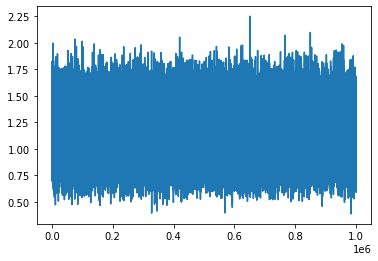

In [15]:
x_in = np.random.poisson(lam=1, size=(5000, 1000000))
x_in = scipy.signal.savgol_filter(x_in, 101, 3)
x_in = x_in + np.random.poisson(lam=1, size=x_in.shape)/10

plt.figure()
plt.plot(x_in[0])

In [16]:
@njit(parallel=True)
# @njit
def rolling_ptile_new(x_in, win_len, ptile, x_win_sorted):
        
    win_len_half = int(win_len/2)
    win_len_half
    idx_ptile = int(win_len * (ptile/100))

    # initialize output
    out_ptile = np.empty_like(x_in)
    out_ptile[:] = np.nan
#     out_ptile[:,0] = x_win_sorted[:,idx_ptile]

    for jj in prange(x_in.shape[0]):
        for ii in range(win_len_half, x_in.shape[1] - win_len_half-1):
            out_ptile[jj][ii] = x_win_sorted[jj][idx_ptile]

            # centered rolling window
            idx_new = ii + win_len_half + 1
            val_new = x_in[:, idx_new]

            idx_old = ii-win_len_half
            val_old = x_in[:, idx_old]

            # for each trace
#             with objmode(tic='f8'):
#                 tic = time()
            found, idx_ins = binary_search(x_win_sorted[jj], 0, win_len-1, val_new[jj])
            found, idx_del = binary_search(x_win_sorted[jj], 0, win_len-1, val_old[jj])
#             with objmode():
#                 print(time() - tic)
#             print(1)
    
            idx_l, idx_r, shift = find_shift_params(idx_del, idx_ins, shift=1)

            shift_chunk_inplace(x_win_sorted[jj], idx_l, idx_r, shift=shift)
            if shift==1 or shift==0:
                x_win_sorted[jj][idx_ins] = val_new[jj]
            elif shift==-1:
                x_win_sorted[jj][idx_ins-1] = val_new[jj]

    return out_ptile

In [18]:
# params
win_len = 501
ptile = 50

time my method

In [19]:
2**np.arange(1,18)+1

array([     3,      5,      9,     17,     33,     65,    129,    257,
          513,   1025,   2049,   4097,   8193,  16385,  32769,  65537,
       131073])

In [ ]:
# make first window
wins_toTest = 2**np.arange(1,17)+1
out_times_mine = np.zeros_like(wins_toTest, dtype='float64')
for ii, win_len in enumerate(wins_toTest):
    tic = time()
    x_win_sorted = np.sort(x_in[:, 0:win_len], axis=1)

    # type checking
    # at least the preallocation requires a np.nan compatible data type
    if x_in.dtype != 'float':
        x_in = np.array(x_in, dtype='float64')

    out_ptile = rolling_ptile_new(x_in, win_len, ptile, x_win_sorted)
    toc = time() - tic
    out_times_mine[ii] = float(toc)
    print(toc)

In [ ]:
# make first window
wins_toTest = 2**np.arange(1,17)+1
out_times_pd = np.zeros_like(wins_toTest, dtype='float64')
for ii, win_len in enumerate(wins_toTest):
    tic = time()
    test_pd = rolling_percentile(x_in, ptile=ptile, window=win_len , **{'axis':1, 'min_periods':None})
    toc = time() - tic
    out_times_pd[ii] = float(toc)
    print(toc)

In [ ]:
%matplotlib notebook

complexity_nlogn = 1e-4*wins_toTest*np.log(wins_toTest)
complexity_n = 1e-3*(wins_toTest)
complexity_logn = 1e-1*np.log(wins_toTest)

plt.figure()
plt.plot(wins_toTest, out_times_mine)
plt.plot(wins_toTest, out_times_pd)
# plt.plot(wins_toTest, complexity_n)
# plt.plot(wins_toTest, complexity_logn)
# plt.plot(wins_toTest, complexity_nlogn)

plt.xscale('log')
plt.yscale('log')
# plt.xlim([1, 2e4])
plt.xlabel('window length')
plt.ylabel('time in (s)')
plt.legend(['mine','pandas', 'c*n', 'c*logn', 'c*nlogn'])

time pandas

In [17]:
tic = time()
test_pd = rolling_percentile(x_in, ptile=ptile, window=win_len , **{'axis':1, 'min_periods':None})
print(time() - tic)

1.7930793762207031


compare traces of outputs

In [126]:
import jax

ModuleNotFoundError: No module named 'jax'

<IPython.core.display.Javascript object>


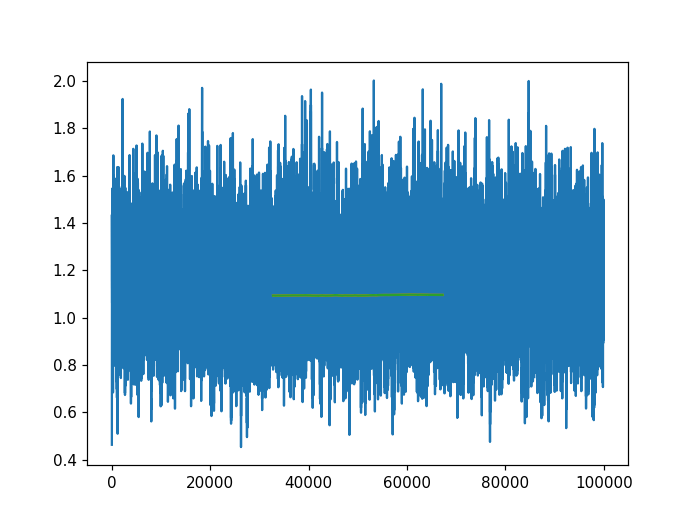

In [125]:
import matplotlib.pyplot as plt

%matplotlib notebook
plt.figure()
plt.plot(x_in[0])
plt.plot(out_ptile[0])
plt.plot(test_pd[0][0:])
# plt.xlim(0,10)

In [397]:
np.allclose(out_ptile[0][5:-5], test_pd[0][5:-5])

True

In [ ]:
np.sort(x_in[0,(ii-win_len_half):ii+win_len_half+1])

some tests

#### integration tests

#### unit tests

In [357]:
# test shift_chunk

print(f'testing output version')

x_test = np.array([0,1,2,3,4,5])
out_test = shift_chunk(x_test, 1,3, shift=1)
pass_test = np.allclose(out_test, np.array([0, 1, 1, 2, 3, 5]))
print(f'positive shift test pass: {pass_test}')

out_test = shift_chunk(x_test, 1,3, -1)
pass_test = np.allclose(out_test, np.array([1,2,3,3,4,5]))
print(f'negative shift test pass: {pass_test}')

out_test = shift_chunk(x_test, 1,3, 0)
pass_test = np.allclose(out_test, np.array([0,1,2,3,4,5]))
print(f'negative shift test pass: {pass_test}')

print()
print(f'testing inplace version')

x_test = np.array([0,1,2,3,4,5])
shift_chunk_inplace(x_test, 1,3, shift=1)
pass_test = np.allclose(x_test, np.array([0, 1, 1, 2, 3, 5]))
print(f'positive shift test pass: {pass_test}')

x_test = np.array([0,1,2,3,4,5])
shift_chunk_inplace(x_test, 1,3, -1)
pass_test = np.allclose(x_test, np.array([1,2,3,3,4,5]))
print(f'negative shift test pass: {pass_test}')

x_test = np.array([0,1,2,3,4,5])
shift_chunk_inplace(x_test, 1,3, 0)
pass_test = np.allclose(x_test, np.array([0,1,2,3,4,5]))
print(f'negative shift test pass: {pass_test}')

testing output version
positive shift test pass: True
negative shift test pass: True
negative shift test pass: True

testing inplace version
positive shift test pass: True
negative shift test pass: True
negative shift test pass: True


In [358]:
# test binary_search
x_test = np.array([0,1,3,3.5,4,4,5,5,5,50])
vals_toTest = np.array([-np.inf, -1, 0, 0, 0, 0.1, 0.5, 0.99999999, 1, 3, 3.25, 3.5, 3.75, 4, 4, 5, 5, 6, 50, 51, np.inf])
idx = np.ones(len(vals_toTest))*-9
found = np.ones(len(vals_toTest))*-9
for ii,val in enumerate(vals_toTest):
    found[ii], idx[ii] = binary_search(x_test, 0, len(x_test)-1, val)
pass_test = np.allclose(found, np.array([0,0,1,1,1,0,0,0,1,1,0,1,0,1,1,1,1,0,1,0,0]))
print(f'found test pass: {pass_test}')
np.allclose(idx, np.array([0,0,0,0,0,1,1,1,1,2,3,3,4,4,4,7,7,9,9,10,10]))
print(f'idx test pass: {pass_test}')

found test pass: True
idx test pass: True


In [362]:
# test find_shift_params
idx_del = 3
idx_ins = 7
shift = 1
idx_l, idx_r, shift = find_shift_params(idx_del, idx_ins, shift=shift)
test_pass = np.allclose( np.array([idx_l, idx_r, shift]) , np.array([4,6,-1]) )
print(f'negative shift test pass: {test_pass}')

idx_del = 5
idx_ins = 2
shift = 1
idx_l, idx_r, shift = find_shift_params(idx_del, idx_ins, shift=shift)
np.array([idx_l, idx_r, shift]) 
test_pass = np.allclose( np.array([idx_l, idx_r, shift]) , np.array([2,4,1]) )
print(f'positive shift test pass: {test_pass}')

idx_del = 2
idx_ins = 2
shift = 1
idx_l, idx_r, shift = find_shift_params(idx_del, idx_ins, shift=shift)
np.array([idx_l, idx_r, shift]) 
test_pass = np.allclose( np.array([idx_l, idx_r, shift]) , np.array([-1,-1,0]) )
print(f'positive shift test pass: {test_pass}')


negative shift test pass: True
positive shift test pass: True
positive shift test pass: True


extra code